# WEEK 5:

In this notebook we will only put a few comments for structure. Further explanations are to be taken from the corresponding report pdf.

In [113]:
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import requests
import geocoder # import geocoder
from geopy.geocoders import Nominatim 
import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
CLIENT_ID = 'NNO2TDZ2XO2YHCMISLHPTUFBAK0YDZBX3RTF04YY4Q5FVR1W' # your Foursquare ID
CLIENT_SECRET = 'UTNENPNX0IFTQP1VPKXI035AFXQEC5XJCN0XJ5YRMYB05HAH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [115]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500, LIMIT=20000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [116]:
def clusterCorrelations(corr_matrix, cluster_number, sortby_corr_strength=False):
    kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(corr_matrix)
    corr_matrix['cluster_labels']=kmeans.labels_
        
    cluster_labels_df=corr_matrix['cluster_labels'].value_counts().to_frame()
    cluster_labels_df=cluster_labels_df.rename(columns={'cluster_labels': 'cluster_size'})
    
    for i in range(0, cluster_number):
        cluster_types=corr_matrix[corr_matrix.cluster_labels==i].index.values.tolist()
        cluster_labels_df.loc[i, 'corr_strength']= np.abs(corr_matrix.loc[cluster_types, cluster_types].mean().mean())
        
    cluster_labels_df['new label']=1
    if sortby_corr_strength:
        cluster_labels_df['new label']=cluster_labels_df.sort_values('corr_strength', ascending=False)['new label'].cumsum()
        cluster_size_list=cluster_labels_df.sort_values('corr_strength', ascending=False).cluster_size.values.tolist()
        display(cluster_labels_df[['new label', 'corr_strength', 'cluster_size']].sort_values('corr_strength', ascending=False))

    else:
        cluster_labels_df['new label']=cluster_labels_df['new label'].cumsum()
        luster_size_list=cluster_labels_df.cluster_size.values.tolist()
        display(cluster_labels_df[['new label', 'corr_strength', 'cluster_size']])
    
    corr_matrix['cluster_labels']=corr_matrix['cluster_labels'].apply(lambda x: cluster_labels_df.loc[x]['new label'])    
    clustered_venues=corr_matrix.sort_values('cluster_labels').index.values.tolist()
    corr_matrix=corr_matrix.loc[clustered_venues, clustered_venues+ ['cluster_labels']]    
        
    for i in range(cluster_number):
        print('\n Cluster {}:'.format(i+1), corr_matrix[corr_matrix.cluster_labels==i+1].index.values.tolist())
        
    fig, (ax1, ax2)=plt.subplots(1,2)
    ax1.imshow(corr_matrix.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')
    ax2.imshow(corr_matrix.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')    
    
    cluster_line=0
    for cluster_size in cluster_size_list:
        cluster_line+=cluster_size
        ax2.axhline(cluster_line-0.5)
        ax2.axvline(cluster_line-0.5)
    
    plt.show()

### Scrape the Table on the given Wikipedia Page with Beautiful Soup and Display the head of the DataFrame

In [117]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
headers = {'User-Agent': 'Mozilla/5.0'}
page = requests.get(url, headers=headers)

In [118]:
soup = BeautifulSoup(page.text, "html.parser")
table = soup.find('table')
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
df=pd.DataFrame(l, columns=["Postcode", "Borough", "Neighbourhood"])
df=df[df['Borough']!='Not assigned'].dropna()
df['Neighbourhood']=df['Neighbourhood'].str.replace('\n','')

In [119]:
df

,Postcode,Borough,Neighbourhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights
8,M6A,North York,Lawrence Manor
9,M7A,Queen's Park,Not assigned
11,M9A,Etobicoke,Islington Avenue
12,M1B,Scarborough,Rouge
13,M1B,Scarborough,Malvern


In [120]:
# Group together rows with the same postalcode as required
df=df.groupby(['Postcode', 'Borough']).agg(lambda col: ', '.join(col)).reset_index()

# Fill 'Not- assigned'-values in Neighbourhood-Column with Borough-Name and display the changed rows
na_idx=df[df.Neighbourhood.str.contains('Not assigned')].index
df.loc[na_idx,'Neighbourhood']=df.loc[na_idx,'Borough']

### Filter on Toronto Boroughs only
toronto_df=df[df.Borough.str.contains('Toronto')]

# Load coordinates and merge
coordinates=pd.read_csv('Geospatial_Coordinates.csv')
toronto_df=pd.merge(toronto_df, coordinates, left_on='Postcode', right_on='Postal Code').drop('Postal Code', axis=1)

In [121]:
toronto_df

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


### Get Venues Nearby

In [122]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

### One hot-encoding for the venues

In [123]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = toronto_onehot.columns.tolist()
fixed_columns.remove('Neighborhood')
fixed_columns = ['Neighborhood'] + fixed_columns
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head(3)

,Neighborhood,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nudist Beach,Optical Shop,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pide Place,Pizza Place,Playground,Plaza,Pool Hall,Pub,Racetrack,Ramen Restaurant,Record Shop,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# Cluster Venues bases on Corrleation of their occurences

## Filter on Top Venues only in order to avoid getting high correlations due to single/low-number data points

In [124]:
pd.options.display.max_rows=20
pd.options.display.max_columns=1000

In [125]:
venue_count=toronto_onehot.drop('Neighborhood', axis=1).T.sum(axis=1).to_frame()
venue_count=venue_count.rename(columns={0:'count'})
venue_count=venue_count.sort_values('count', ascending=False)
top_venue_types=venue_count.iloc[0:int(venue_count.shape[0]/4)].index.values.tolist()
venue_count

,count
Coffee Shop,266
Café,233
Park,163
Italian Restaurant,157
Bakery,89
Pizza Place,87
Hotel,83
Japanese Restaurant,74
Bar,71
Restaurant,68


In [126]:
toronto_onehot=toronto_onehot[['Neighborhood']+top_venue_types]

# Get Correlation for different vanues based on the data of different neighborhoods

In [127]:
toronto_venues=toronto_onehot.groupby(['Neighborhood']).sum()
toronto_venues.head(3)

,Coffee Shop,Café,Park,Italian Restaurant,Bakery,Pizza Place,Hotel,Japanese Restaurant,Bar,Restaurant,Gastropub,Sushi Restaurant,Gym,Ice Cream Shop,Dessert Shop,American Restaurant,Bookstore,Theater,Thai Restaurant,Beer Bar,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Brewery,Diner,Indian Restaurant,Farmers Market,French Restaurant,Yoga Studio,Breakfast Spot,Plaza,Sporting Goods Shop,BBQ Joint,Pub,Sandwich Place,Grocery Store,Steakhouse,Vietnamese Restaurant,Tea Room,Concert Hall,Spa,Mexican Restaurant,Cocktail Bar,Asian Restaurant,Arts & Crafts Store,Mediterranean Restaurant,Liquor Store,Movie Theater,Ramen Restaurant,Art Gallery,Burger Joint,Comic Shop,Supermarket
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",6,3,1,1,0,4,6,2,0,3,1,1,3,0,2,2,2,4,2,3,1,2,1,2,0,2,1,1,1,2,2,1,1,2,0,1,0,1,2,0,0,0,0,1,1,0,1,0,2,0,1,0
Berczy Park,10,7,3,4,1,1,5,2,0,2,3,0,2,1,2,2,1,4,2,1,1,2,1,1,0,3,0,0,1,2,1,1,1,0,1,2,0,0,2,0,0,0,0,0,1,1,1,0,0,0,0,1
"Brockton, Exhibition Place, Parkdale Village",5,8,3,2,4,1,3,2,5,5,0,0,1,1,0,2,1,1,1,1,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,2,2,0,0,1,3,3,1,0,0,1,0,1,0,0,0


In [128]:
venue_corr=toronto_venues.corr()

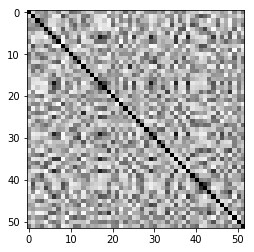

In [129]:
plt.imshow(venue_corr,cmap='Greys',interpolation='nearest')

In [130]:
scores=list()

for kclusters in range(1,venue_corr.shape[0]):
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_corr)
    scores.append(kmeans.score(venue_corr))

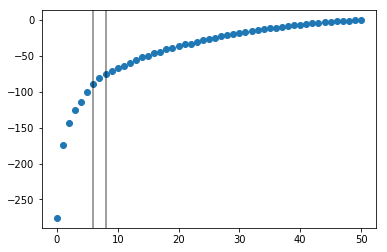

In [131]:
plt.axvline(6, color='k', alpha=0.5)
plt.axvline(8, color='k', alpha=0.5)
plt.scatter(np.linspace(0,len(scores)-1,len(scores)), scores)

Number of clusters 4


,new label,corr_strength,cluster_size
3,1,0.440933,14
0,2,0.369309,9
2,3,0.262791,12
1,4,0.255813,17



 Cluster 1: ['Farmers Market', 'Steakhouse', 'Sporting Goods Shop', 'Plaza', 'Diner', 'Mediterranean Restaurant', 'Theater', 'Bookstore', 'Gym', 'Movie Theater', 'Thai Restaurant', 'Concert Hall', 'Japanese Restaurant', 'Hotel']

 Cluster 2: ['Sandwich Place', 'Art Gallery', 'Comic Shop', 'Vegetarian / Vegan Restaurant', 'Pizza Place', 'Restaurant', 'Arts & Crafts Store', 'American Restaurant', 'Beer Bar']

 Cluster 3: ['Café', 'Bar', 'Mexican Restaurant', 'Cocktail Bar', 'Vietnamese Restaurant', 'French Restaurant', 'Dessert Shop', 'Ramen Restaurant', 'Bakery', 'Brewery', 'Yoga Studio', 'Asian Restaurant']

 Cluster 4: ['Liquor Store', 'Burger Joint', 'Spa', 'Coffee Shop', 'Grocery Store', 'Pub', 'BBQ Joint', 'Breakfast Spot', 'Indian Restaurant', 'Middle Eastern Restaurant', 'Ice Cream Shop', 'Sushi Restaurant', 'Gastropub', 'Italian Restaurant', 'Park', 'Tea Room', 'Supermarket']


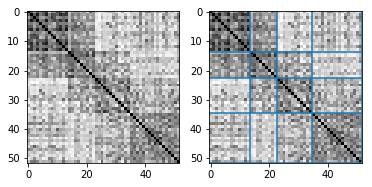

Number of clusters 5


,new label,corr_strength,cluster_size
3,1,0.494104,7
0,2,0.440933,14
2,3,0.369309,9
4,4,0.362063,7
1,5,0.283763,15



 Cluster 1: ['Café', 'Bakery', 'Vietnamese Restaurant', 'Bar', 'Brewery', 'Cocktail Bar', 'Asian Restaurant']

 Cluster 2: ['Farmers Market', 'Sporting Goods Shop', 'Plaza', 'Concert Hall', 'Diner', 'Thai Restaurant', 'Theater', 'Steakhouse', 'Bookstore', 'Gym', 'Mediterranean Restaurant', 'Movie Theater', 'Hotel', 'Japanese Restaurant']

 Cluster 3: ['Arts & Crafts Store', 'Art Gallery', 'Pizza Place', 'Comic Shop', 'Sandwich Place', 'Restaurant', 'Vegetarian / Vegan Restaurant', 'Beer Bar', 'American Restaurant']

 Cluster 4: ['Spa', 'Ramen Restaurant', 'Mexican Restaurant', 'Supermarket', 'Dessert Shop', 'Yoga Studio', 'French Restaurant']

 Cluster 5: ['Burger Joint', 'Park', 'Italian Restaurant', 'Gastropub', 'Liquor Store', 'Sushi Restaurant', 'Grocery Store', 'Pub', 'Middle Eastern Restaurant', 'Indian Restaurant', 'Tea Room', 'Breakfast Spot', 'BBQ Joint', 'Ice Cream Shop', 'Coffee Shop']


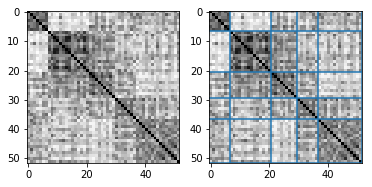

Number of clusters 6


,new label,corr_strength,cluster_size
0,1,0.684999,8
2,2,0.494104,7
4,3,0.399499,6
5,4,0.369309,9
3,5,0.362063,7
1,6,0.283763,15



 Cluster 1: ['Farmers Market', 'Thai Restaurant', 'Mediterranean Restaurant', 'Theater', 'Concert Hall', 'Hotel', 'Steakhouse', 'Plaza']

 Cluster 2: ['Bakery', 'Brewery', 'Cocktail Bar', 'Café', 'Asian Restaurant', 'Vietnamese Restaurant', 'Bar']

 Cluster 3: ['Diner', 'Sporting Goods Shop', 'Bookstore', 'Gym', 'Movie Theater', 'Japanese Restaurant']

 Cluster 4: ['Arts & Crafts Store', 'Beer Bar', 'Vegetarian / Vegan Restaurant', 'Restaurant', 'Comic Shop', 'Pizza Place', 'Art Gallery', 'American Restaurant', 'Sandwich Place']

 Cluster 5: ['Mexican Restaurant', 'Spa', 'Ramen Restaurant', 'Supermarket', 'Dessert Shop', 'Yoga Studio', 'French Restaurant']

 Cluster 6: ['Burger Joint', 'Park', 'Italian Restaurant', 'Gastropub', 'Liquor Store', 'Sushi Restaurant', 'Grocery Store', 'Pub', 'Middle Eastern Restaurant', 'Indian Restaurant', 'Tea Room', 'Breakfast Spot', 'BBQ Joint', 'Ice Cream Shop', 'Coffee Shop']


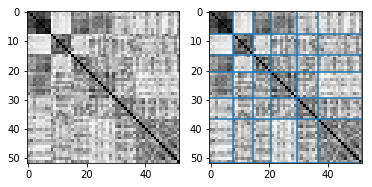

Number of clusters 7


,new label,corr_strength,cluster_size
2,1,0.684999,8
5,2,0.533677,6
3,3,0.494104,7
1,4,0.446302,8
6,5,0.391797,7
4,6,0.362063,7
0,7,0.235594,9



 Cluster 1: ['Farmers Market', 'Plaza', 'Steakhouse', 'Hotel', 'Concert Hall', 'Mediterranean Restaurant', 'Thai Restaurant', 'Theater']

 Cluster 2: ['Sandwich Place', 'Pizza Place', 'Restaurant', 'Art Gallery', 'Beer Bar', 'Arts & Crafts Store']

 Cluster 3: ['Vietnamese Restaurant', 'Brewery', 'Asian Restaurant', 'Bar', 'Bakery', 'Café', 'Cocktail Bar']

 Cluster 4: ['Ice Cream Shop', 'Liquor Store', 'Middle Eastern Restaurant', 'Indian Restaurant', 'Italian Restaurant', 'Grocery Store', 'Park', 'BBQ Joint']

 Cluster 5: ['Pub', 'Burger Joint', 'Tea Room', 'Coffee Shop', 'Breakfast Spot', 'Gastropub', 'Sushi Restaurant']

 Cluster 6: ['Ramen Restaurant', 'Dessert Shop', 'Mexican Restaurant', 'Supermarket', 'French Restaurant', 'Yoga Studio', 'Spa']

 Cluster 7: ['Vegetarian / Vegan Restaurant', 'Bookstore', 'Sporting Goods Shop', 'Diner', 'Gym', 'Comic Shop', 'Movie Theater', 'Japanese Restaurant', 'American Restaurant']


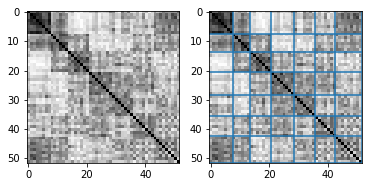

Number of clusters 8


,new label,corr_strength,cluster_size
3,1,0.684999,8
0,2,0.533677,6
6,3,0.494104,7
2,4,0.488519,5
4,5,0.446302,8
1,6,0.391797,7
5,7,0.362063,7
7,8,0.337719,4



 Cluster 1: ['Farmers Market', 'Plaza', 'Concert Hall', 'Mediterranean Restaurant', 'Thai Restaurant', 'Hotel', 'Theater', 'Steakhouse']

 Cluster 2: ['Restaurant', 'Sandwich Place', 'Art Gallery', 'Arts & Crafts Store', 'Beer Bar', 'Pizza Place']

 Cluster 3: ['Bar', 'Vietnamese Restaurant', 'Café', 'Cocktail Bar', 'Asian Restaurant', 'Bakery', 'Brewery']

 Cluster 4: ['Sporting Goods Shop', 'Japanese Restaurant', 'Bookstore', 'Movie Theater', 'Gym']

 Cluster 5: ['Grocery Store', 'Indian Restaurant', 'Liquor Store', 'Park', 'Ice Cream Shop', 'BBQ Joint', 'Middle Eastern Restaurant', 'Italian Restaurant']

 Cluster 6: ['Tea Room', 'Burger Joint', 'Coffee Shop', 'Breakfast Spot', 'Sushi Restaurant', 'Gastropub', 'Pub']

 Cluster 7: ['Yoga Studio', 'Spa', 'Mexican Restaurant', 'French Restaurant', 'Dessert Shop', 'Ramen Restaurant', 'Supermarket']

 Cluster 8: ['Comic Shop', 'Diner', 'Vegetarian / Vegan Restaurant', 'American Restaurant']


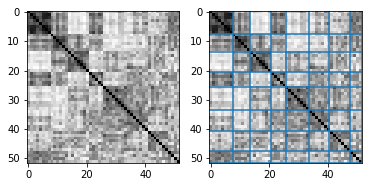

In [132]:
for i in range(4,9):
    print('Number of clusters', i)
    clusterCorrelations(venue_corr, i, True)

# Making predictions for business opportunities

We find a stable cluster of 12 venues wich are correlated the strongest amongst the set of top venues. Let's make predictions for business opportunities for that cluster

In [146]:
stable_cluster= ['Farmers Market', 'Plaza', 'Steakhouse', 'Hotel', 'Concert Hall', 'Mediterranean Restaurant', 'Thai Restaurant', 'Theater']

Since venues might not be only highly correlated because they support each other and therefore occur often together, but also because similar venues compete with each other and fight for the same business opportunities it might not make sense to use all the other venues from the same cluster for business predictions of some type of venues.

For example if we want to make predictions for restaurants we should splot the cluster into restaurants and places that compete with each other (subcluster1) and make predictions for business opportunites simulatneously, relying only on the other venues (subcluster2) as the correlation with those might indicated supporting character and business opportunities based on those venues.

So we will make bases on the venues of subcluster2 predictions for subcluster1

In [147]:
subcluster1=['Steakhouse', 'Mediterranean Restaurant', 'Thai Restaurant']

In [148]:
subcluster2=list(set(stable_cluster).difference(set(subcluster1)))

In [149]:
subcluster1

['Steakhouse', 'Mediterranean Restaurant', 'Thai Restaurant']

In [150]:
subcluster2

['Farmers Market', 'Plaza', 'Theater', 'Concert Hall', 'Hotel']

In [179]:
subcluster1_venues=toronto_venues[subcluster1]

In [180]:
subcluster1_predictions=0*subcluster1_venues.copy()
subcluster1_predictions.head()

,Steakhouse,Mediterranean Restaurant,Thai Restaurant
Neighborhood,,,
"Adelaide, King, Richmond",0,0,0
Berczy Park,0,0,0
"Brockton, Exhibition Place, Parkdale Village",0,0,0
Business Reply Mail Processing Centre 969 Eastern,0,0,0
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0,0,0


In [181]:
from sklearn.linear_model import LinearRegression

In [182]:
for i in subcluster1:
    X=np.array(toronto_venues[subcluster2])
    y=np.array(toronto_venues[[i]])
    reg=LinearRegression(fit_intercept=False).fit(X, y)
    subcluster1_predictions[[i]]=np.dot(np.array(toronto_venues[subcluster2]), np.array(reg.coef_[0]))

In [183]:
subcluster1_venues.head()

,Steakhouse,Mediterranean Restaurant,Thai Restaurant
Neighborhood,,,
"Adelaide, King, Richmond",1,1,2
Berczy Park,2,1,2
"Brockton, Exhibition Place, Parkdale Village",0,0,1
Business Reply Mail Processing Centre 969 Eastern,0,0,0
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",1,1,1


In [184]:
subcluster1_predictions.head()

,Steakhouse,Mediterranean Restaurant,Thai Restaurant
Neighborhood,,,
"Adelaide, King, Richmond",1.563131,1.353034,2.254969
Berczy Park,1.745775,1.139392,2.362033
"Brockton, Exhibition Place, Parkdale Village",-0.230257,0.578186,0.635286
Business Reply Mail Processing Centre 969 Eastern,0.027390,0.284257,0.550327
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0.886487,0.482941,0.946370


We define the business opportunity by the difference between predicted number of venues and actual number of venues

In [190]:
subcluster1_business_opps=subcluster1_predictions[subcluster1]-subcluster1_venues
subcluster1_business_opps['overall opp']=subcluster1_business_opps.sum(axis=1)

In [191]:
subcluster1_business_opps.head()

,Steakhouse,Mediterranean Restaurant,Thai Restaurant,overall opp
Neighborhood,,,,
"Adelaide, King, Richmond",0.563131,0.353034,0.254969,1.171134
Berczy Park,-0.254225,0.139392,0.362033,0.247200
"Brockton, Exhibition Place, Parkdale Village",-0.230257,0.578186,-0.364714,-0.016786
Business Reply Mail Processing Centre 969 Eastern,0.027390,0.284257,0.550327,0.861974
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",-0.113513,-0.517059,-0.053630,-0.684202


In the Follwing Table we see the business opportunities for the venues in subcluster 1, sorted by the overall opportunity per neighborhood

In [199]:
subcluster1_business_opps.sort_values('overall opp', ascending=False).head()

,Steakhouse,Mediterranean Restaurant,Thai Restaurant,overall opp
Neighborhood,,,,
"First Canadian Place, Underground city",1.160317,0.180937,0.299696,1.640949
"Adelaide, King, Richmond",0.563131,0.353034,0.254969,1.171134
Business Reply Mail Processing Centre 969 Eastern,0.027390,0.284257,0.550327,0.861974
St. James Town,0.342961,-0.032706,0.406760,0.717015
"Design Exchange, Toronto Dominion Centre",0.160317,0.180937,0.299696,0.640949


In the follwing 3 tables we see the best business opportunities for each venue type in subcluster 1 and the corresponding overall business opportunity in the corresponding neighborhood

In [195]:
cols=['Steakhouse', 'overall opp']
subcluster1_business_opps[cols].sort_values(cols, ascending=False).head()

,Steakhouse,overall opp
Neighborhood,,
"First Canadian Place, Underground city",1.160317,1.640949
"Adelaide, King, Richmond",0.563131,1.171134
"The Danforth West, Riverdale",0.412011,0.328186
St. James Town,0.342961,0.717015
"The Annex, North Midtown, Yorkville",0.256756,0.114095


In [196]:
cols=['Mediterranean Restaurant', 'overall opp']
subcluster1_business_opps[cols].sort_values(cols, ascending=False).head()

,Mediterranean Restaurant,overall opp
Neighborhood,,
"Brockton, Exhibition Place, Parkdale Village",0.578186,-0.016786
"Harbourfront East, Toronto Islands, Union Station",0.441413,0.169477
"The Danforth West, Riverdale",0.439093,0.328186
"Adelaide, King, Richmond",0.353034,1.171134
Business Reply Mail Processing Centre 969 Eastern,0.284257,0.861974


In [197]:
cols=['Thai Restaurant', 'overall opp']
subcluster1_business_opps[cols].sort_values(cols, ascending=False).head()

,Thai Restaurant,overall opp
Neighborhood,,
"Forest Hill North, Forest Hill West",0.595054,0.331789
Business Reply Mail Processing Centre 969 Eastern,0.550327,0.861974
St. James Town,0.406760,0.717015
Berczy Park,0.362033,0.247200
"Ryerson, Garden District",0.362033,0.247200


We see the Neigboorhood Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West and looking at the overall opportunity we see that is is the least saturated by the 
restaurants in sublcluster1

# Discussion

As we have seen we have built some type of systems to recognize outliers in the expected number of venues, based on the number of other venues with which they correlate, in order to suggest over- and under-saturated markets and find business opportunities.

We have further split a cluster of correlated venues by reason into subclusters of competing similar venues, and other non-competing venues which might then me supportive. With that we have suggested business opportunities for restaurants based on non-restaurant venues they correlate with.

However we should keep in my a few problems.
Our correlations are based on a very small number of venues and neighborhoods.
We might want to get more neighborhoods and data into account, so that we can also calculate correlation of occurences based on a smaller radius and make the whole correlation calculation more likely to reflect a connection between different venues.

Furthermore we need more statistic to make significance tests. To be able to confidently say that we have found an business opportunity, we would need to make sure that the deviation between predicted value and real value is big enough so that it is a statistical outlier and could be interpreted as a special event, rather than usual statistical error.

Also one might want to use more complex models such a polynomial regression, random forests and neural networks, instead of just using a linear. But again for such complex models we have to extend our approach to use much more data.